## Importing all JSON data and put it into one DataFrame

We will import all the JSON files from the specified folder and store them in a single DataFrame.
This is basicly how garmin will export sleep data to you

In [101]:
import os
import json
import pandas as pd

data_folder = './data'

json_files = [file for file in os.listdir(data_folder) if file.endswith('.json')]

data_list = []
for file in json_files:
    with open(os.path.join(data_folder, file), 'r') as f:
        json_data = json.load(f)
        
        # Check if 'sleepScores' key exists and extract its values into new keys
        if 'sleepScores' in json_data:
            for key, value in json_data['sleepScores'].items():
                json_data[f'sleepScores_{key}'] = value
            del json_data['sleepScores']
        
        # Convert the dictionary into a pandas DataFrame and append to data_list
        data_list.append(pd.json_normalize(json_data))

data = pd.concat(data_list, ignore_index=True)



## Cleaning Up the Data

We will convert the necessary columns to datetime objects and filter out rows with invalid time information. Additionally, we will drop unnecessary columns.


In [102]:
import pandas as pd
from datetime import datetime, time

def has_time_info(timestamp):
    if isinstance(timestamp, str):
        time_format = "%Y-%m-%dT%H:%M:%S.%f"
        try:
            dt = datetime.strptime(timestamp, time_format)
            return dt.time() != time(0, 0)
        except ValueError:
            return False
    elif isinstance(timestamp, pd.Timestamp):
        return timestamp.time() != time(0, 0)
    else:
        raise ValueError("Unsupported input type")

# Convert date columns to datetime objects
data['sleepStartTimestampGMT'] = pd.to_datetime(data['sleepStartTimestampGMT'])
data['sleepEndTimestampGMT'] = pd.to_datetime(data['sleepEndTimestampGMT'])
data['calendarDate'] = pd.to_datetime(data['calendarDate'])

# Filter rows with valid time information in the sleepStartTimestampGMT column
data = data[data['sleepStartTimestampGMT'].apply(has_time_info)]

# Filter rows with valid time information in the sleepEndTimestampGMT column
data = data[data['sleepEndTimestampGMT'].apply(has_time_info)]

columns_to_drop = [
    'spo2SleepSummary.userProfilePk',
    'spo2SleepSummary.deviceId',
    'spo2SleepSummary.sleepMeasurementStartGMT',
    'spo2SleepSummary.sleepMeasurementEndGMT',
    'spo2SleepSummary.averageSPO2',
    'spo2SleepSummary.averageHR',
    'spo2SleepSummary.lowestSPO2',
]

# Remove columns only if they exist in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)


## Checking Timestamps

We will verify if all timestamps have non-zero time components.


In [103]:
# Check if all timestamps have a non-zero time component
has_time_component = all(
    data.loc[:, 'sleepStartTimestampGMT'].apply(lambda x: x.hour != 0 or x.minute != 0 or x.second != 0)
    & data.loc[:, 'sleepEndTimestampGMT'].apply(lambda x: x.hour != 0 or x.minute != 0 or x.second != 0)
)

print("All timestamps have a non-zero time component:", has_time_component)

has_zero_time = (data['sleepStartTimestampGMT'].dt.strftime('%H%M%S') == '000000').any()
print(f"All timestamps have a non-zero time component: {not has_zero_time}")


All timestamps have a non-zero time component: True
All timestamps have a non-zero time component: True


## Sleep Scores Feedback Distribution

We will create a bar plot to visualize the distribution of sleep scores feedback.


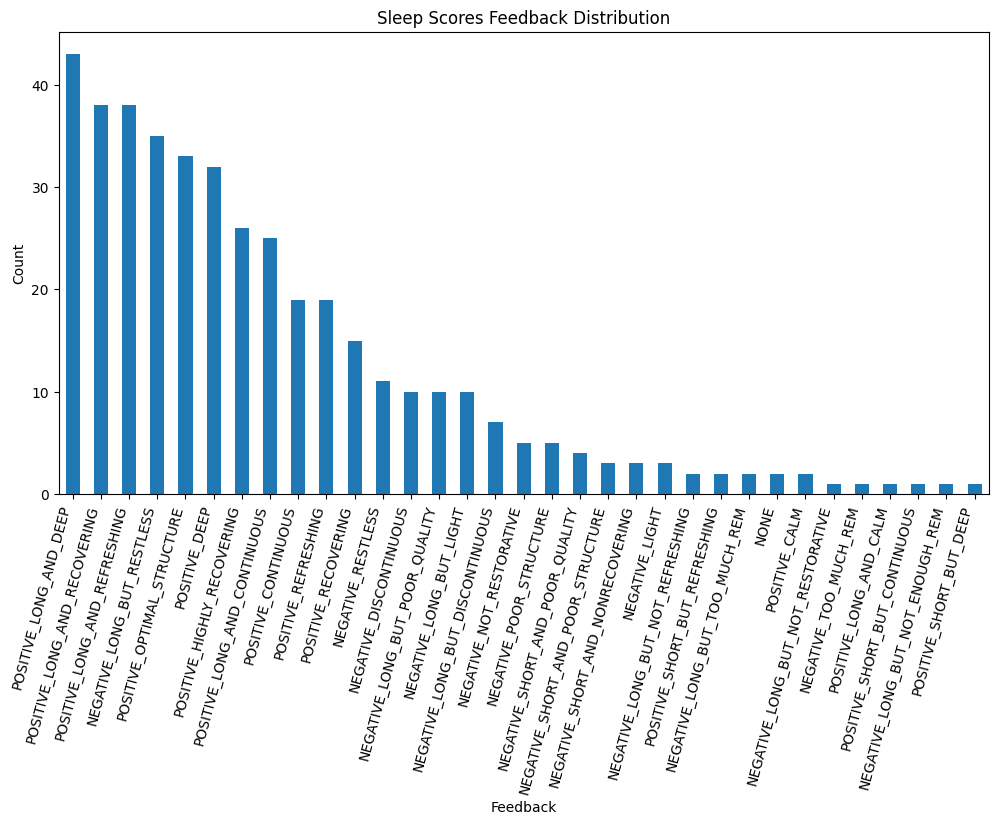

In [104]:
import matplotlib.pyplot as plt
feedback_counts = data['sleepScores.feedback'].value_counts()

plt.figure(figsize=(12, 6))

ax = feedback_counts.plot(kind='bar')
ax.set_xlabel('Feedback')
ax.set_ylabel('Count')
ax.set_title('Sleep Scores Feedback Distribution')

plt.xticks(rotation=75, ha='right')

plt.show()




## Basic Statistics and Correlations

We will calculate basic statistics like mean sleep duration, deep sleep, light sleep, and REM sleep. We will also calculate correlations for numeric columns.


In [105]:
# Calculate basic statistics
mean_sleep_duration = data['sleepEndTimestampGMT'] - data['sleepStartTimestampGMT']
mean_sleep_duration = mean_sleep_duration.mean()

mean_deep_sleep = data['deepSleepSeconds'].mean()
mean_light_sleep = data['lightSleepSeconds'].mean()
mean_rem_sleep = data['remSleepSeconds'].mean()

# Calculate correlations for numeric columns only
numeric_data = data.select_dtypes(include=['number'])
correlations = numeric_data.corr()


## Sleep Start Time and End Time Distributions

We will create bar plots to visualize the distributions of sleep start times and sleep end times.


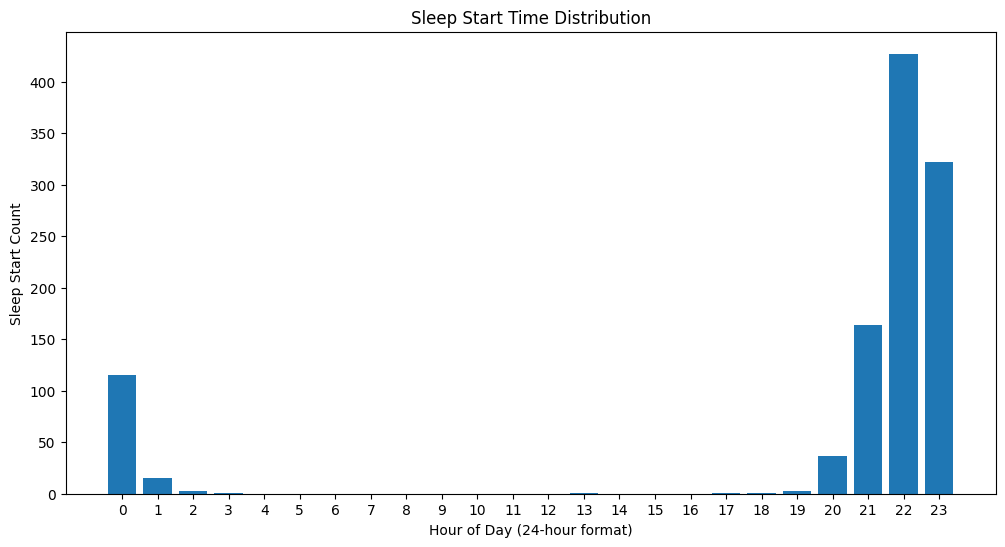

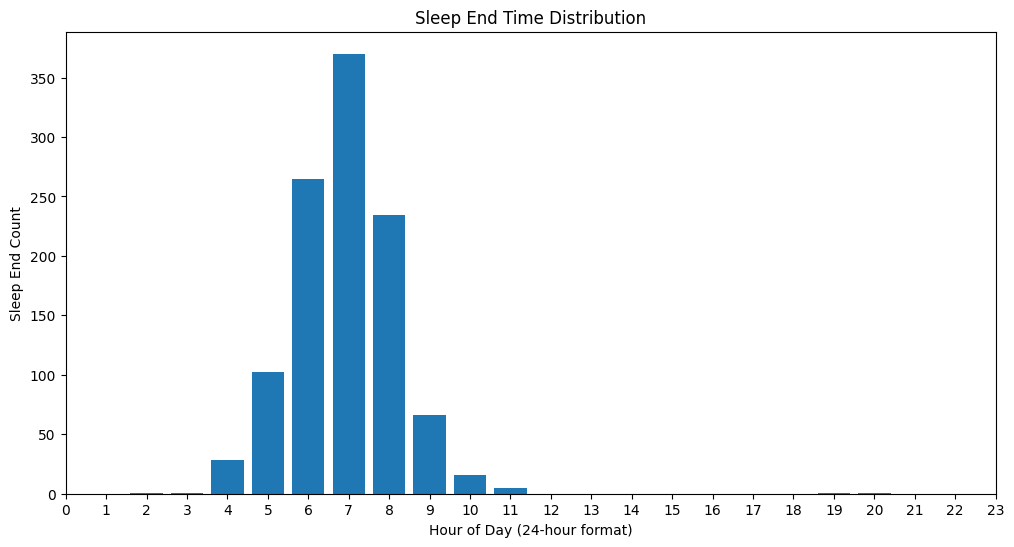

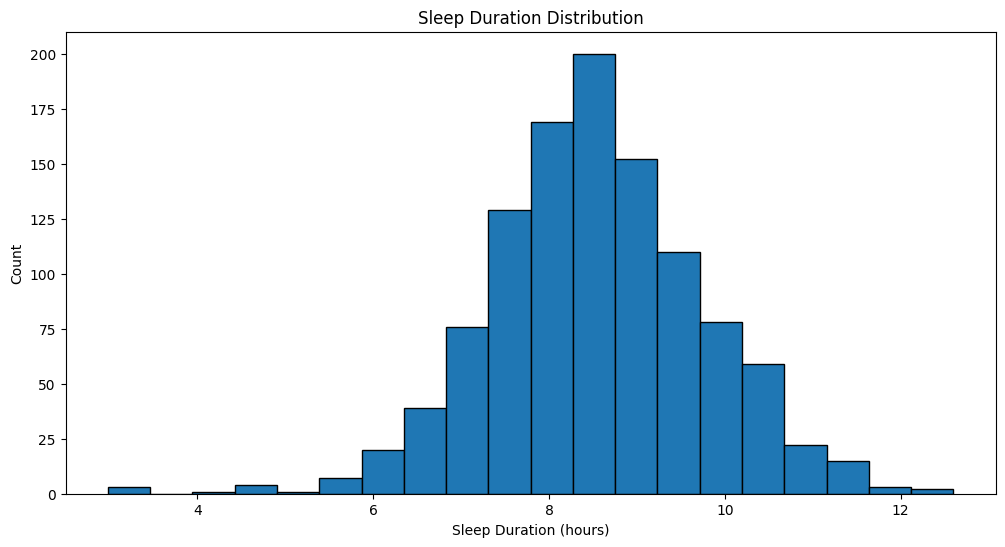

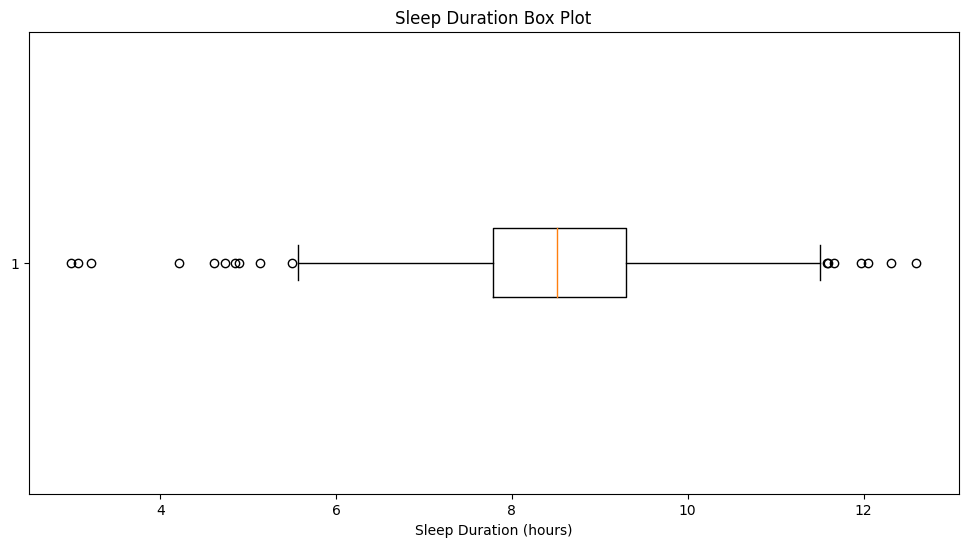

In [106]:
data['sleep_hour'] = data['sleepStartTimestampGMT'].dt.hour
hourly_counts = data.groupby('sleep_hour').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts['sleep_hour'], hourly_counts['count'])
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Sleep Start Count')
plt.title('Sleep Start Time Distribution')
plt.xticks(range(0, 24))
plt.show()

data['wake_hour'] = data['sleepEndTimestampGMT'].dt.hour
hourly_wake_counts = data.groupby('wake_hour').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
plt.bar(hourly_wake_counts['wake_hour'], hourly_wake_counts['count'])
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Sleep End Count')
plt.title('Sleep End Time Distribution')
plt.xticks(range(0, 24))
plt.show()

data['sleep_duration'] = (data['sleepEndTimestampGMT'] - data['sleepStartTimestampGMT']).dt.total_seconds() / 3600

plt.figure(figsize=(12, 6))
plt.hist(data['sleep_duration'], bins=20, edgecolor='black')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Count')
plt.title('Sleep Duration Distribution')
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot(data['sleep_duration'], vert=False)
plt.xlabel('Sleep Duration (hours)')
plt.title('Sleep Duration Box Plot')
plt.show()



### Visualizing Correlations and Relationship Between Deep Sleep and REM Sleep Scores

In this section, we'll create a heatmap to visualize the correlations between the numeric columns in our sleep data. 
This will help us identify any strong relationships between different sleep parameters.

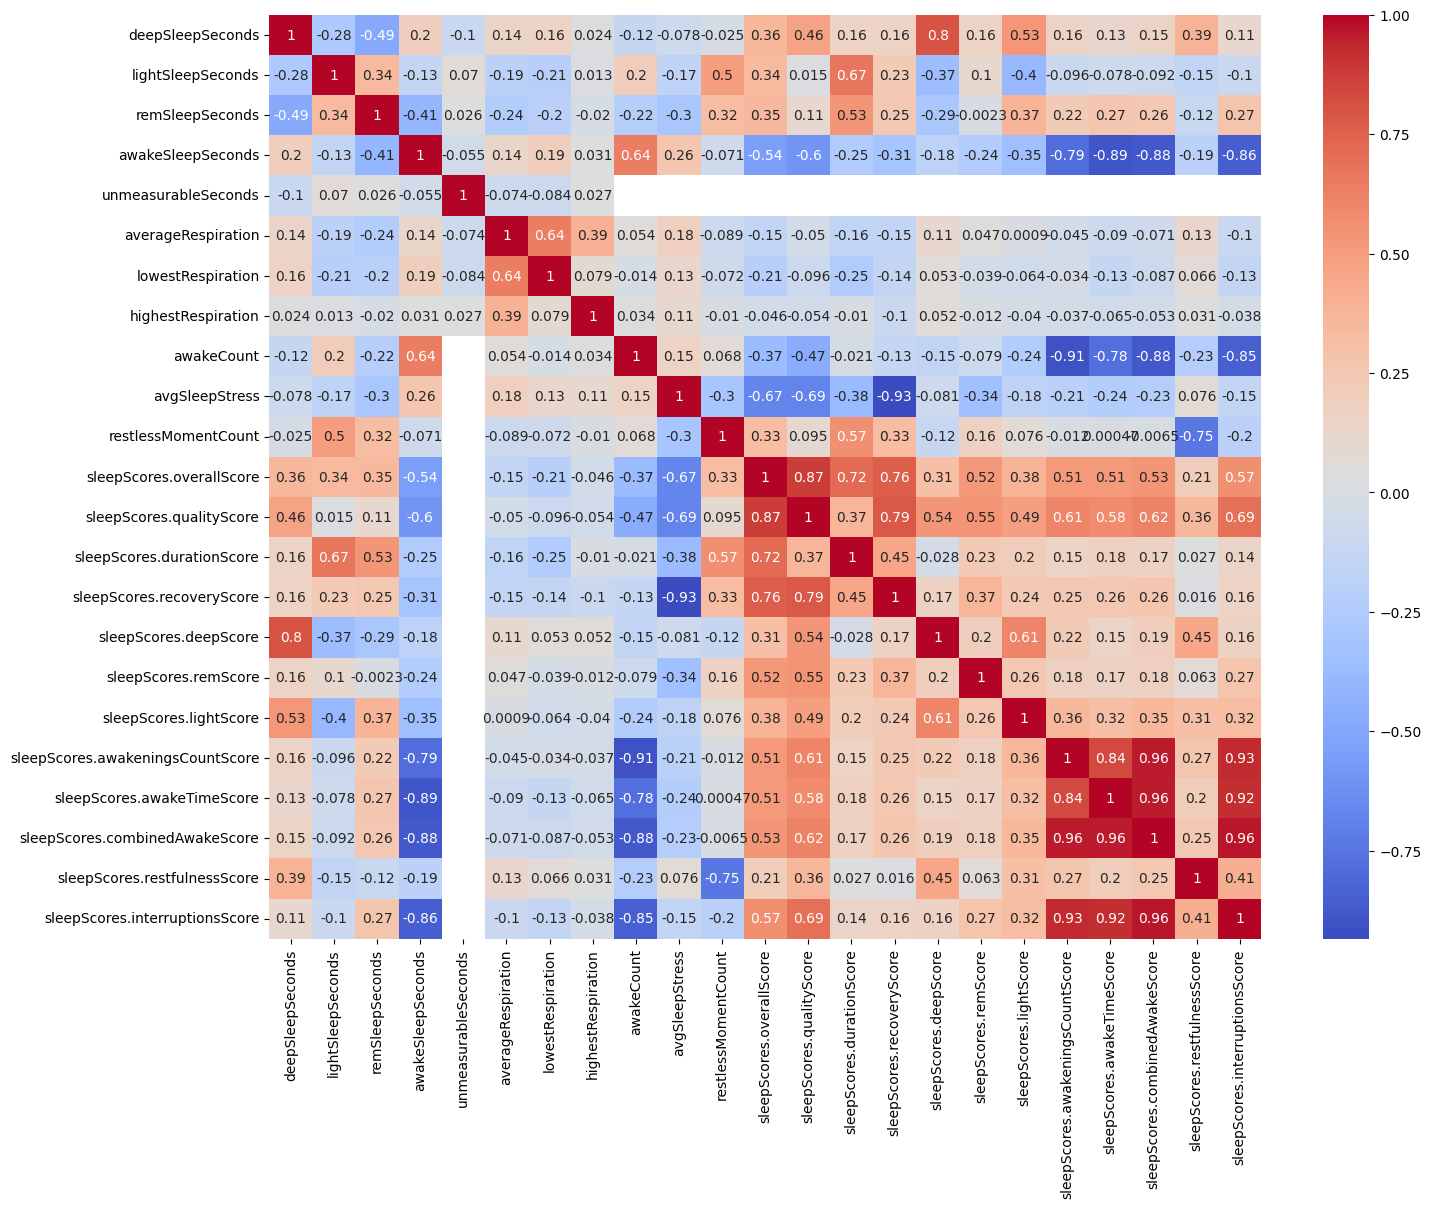

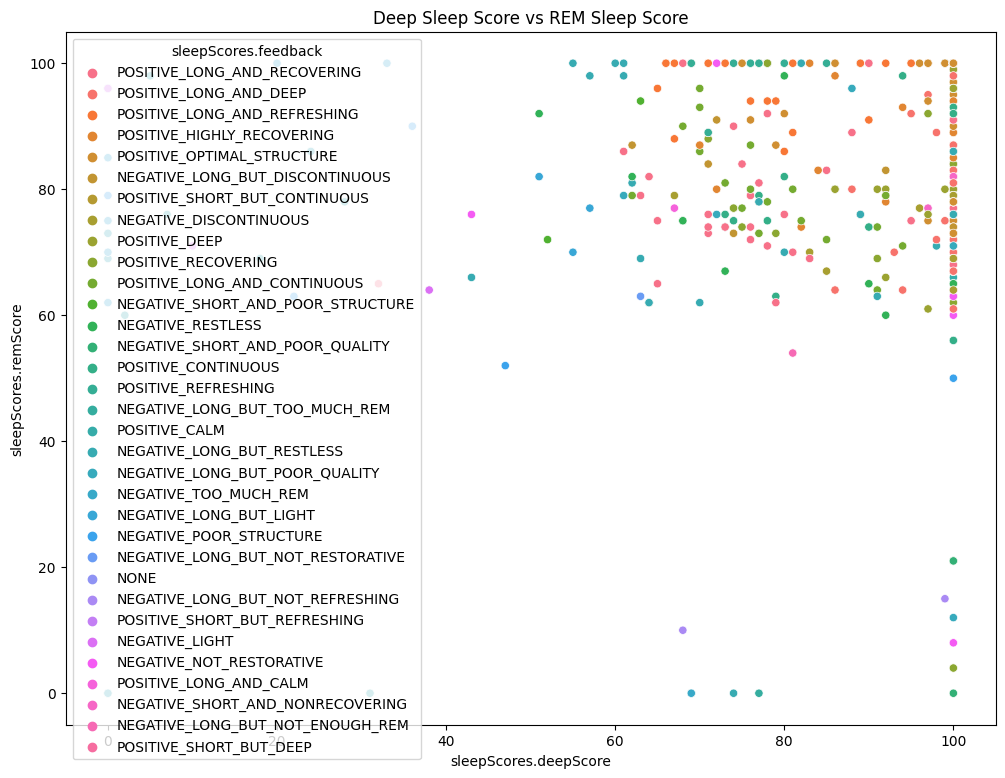

In [107]:
# Visualize correlations as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

# Visualize the relationship between deep sleep and REM sleep scores
plt.figure(figsize=(12, 9))
sns.scatterplot(x='sleepScores.deepScore', y='sleepScores.remScore', hue='sleepScores.feedback', data=data)
plt.title("Deep Sleep Score vs REM Sleep Score")
plt.show()


### Visualizing the Ratio of Positive and Negative Feedback

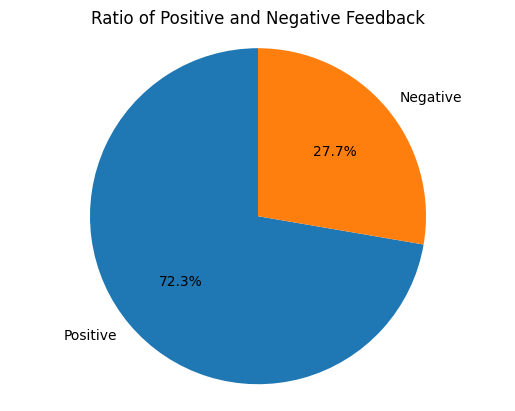

In [108]:
positive_count = data['sleepScores.feedback'].str.contains('POSITIVE').sum()
negative_count = data['sleepScores.feedback'].str.contains('NEGATIVE').sum()

feedback_summary = pd.Series({'Positive': positive_count, 'Negative': negative_count})

fig, ax = plt.subplots()
feedback_summary.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90)
ax.set_ylabel('')
ax.set_title('Ratio of Positive and Negative Feedback')
plt.axis('equal')  # Ensures that the pie chart is a circle
plt.show()



### Invest if a sleep more in different seasons

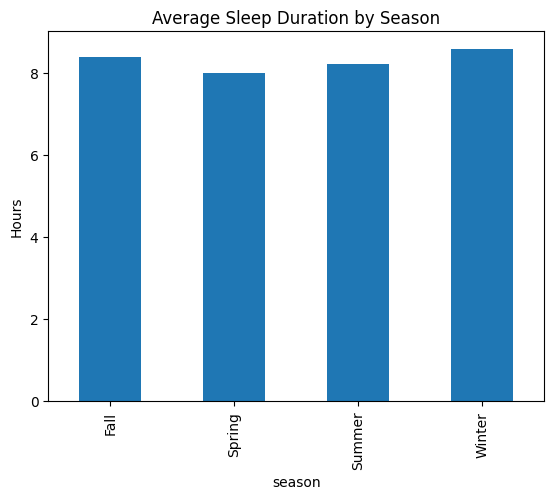

In [109]:
def get_season(date_string):
    date = pd.to_datetime(date_string)
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

data['season'] = data['calendarDate'].apply(get_season)

data['totalSleepSeconds'] = data['deepSleepSeconds'] + data['lightSleepSeconds'] + data['remSleepSeconds']
average_sleep_duration_by_season = data.groupby('season')['totalSleepSeconds'].mean() / 3600

average_sleep_duration_by_season.plot(kind='bar', title='Average Sleep Duration by Season')
plt.ylabel('Hours')
plt.show()




### Better visualisation of the different sleep times

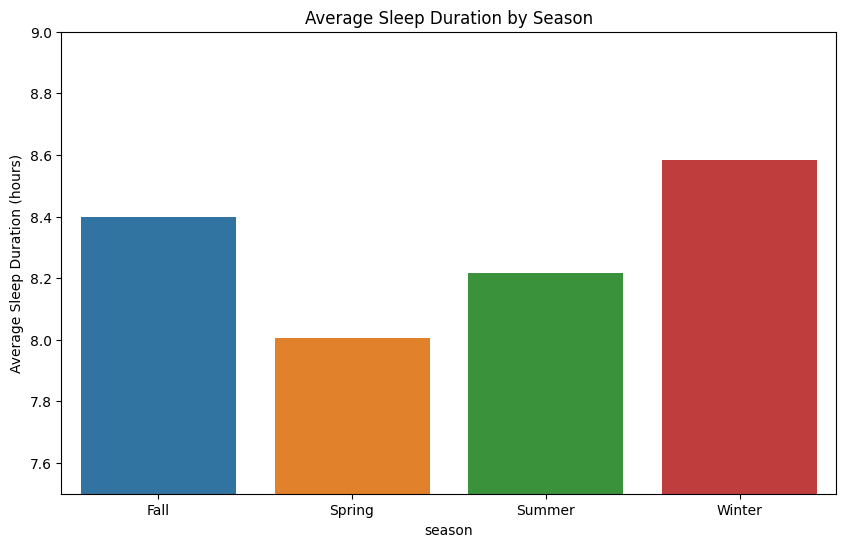

In [110]:
season_averages = data.groupby('season')['totalSleepSeconds'].mean() / 3600
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=season_averages.index, y=season_averages.values)
ax.set_ylim(7.5, 9)  # Adjust y-axis limits for better visibility of the differences
ax.set_ylabel('Average Sleep Duration (hours)')
ax.set_title('Average Sleep Duration by Season')
plt.show()


### Analyze if I sleep more on the weekends vs weekdays

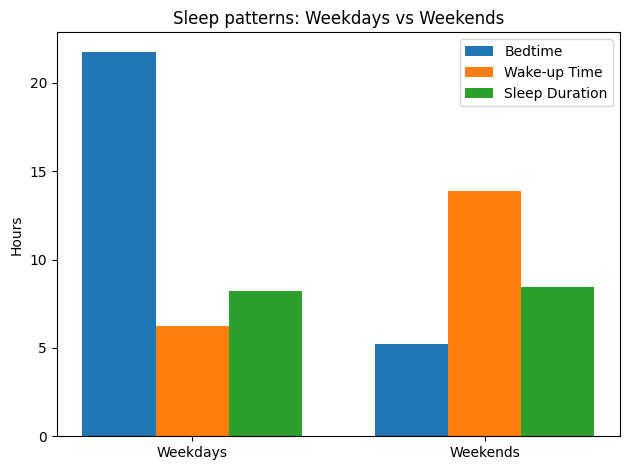

In [111]:
data['calendarDate'] = pd.to_datetime(data['calendarDate'])

data['day_of_week'] = data['calendarDate'].dt.dayofweek

weekdays = data[data['day_of_week'] < 5]
weekends = data[data['day_of_week'] >= 5]

avg_bedtime_weekdays = pd.to_datetime(weekdays['sleepStartTimestampGMT']).mean()
avg_bedtime_weekends = pd.to_datetime(weekends['sleepStartTimestampGMT']).mean()

avg_wakeup_weekdays = pd.to_datetime(weekdays['sleepEndTimestampGMT']).mean()
avg_wakeup_weekends = pd.to_datetime(weekends['sleepEndTimestampGMT']).mean()


avg_sleep_duration_weekdays = weekdays['totalSleepSeconds'].mean() / 3600  # convert to hours
avg_sleep_duration_weekends = weekends['totalSleepSeconds'].mean() / 3600  # convert to hours

labels = ['Weekdays', 'Weekends']
bedtimes = [avg_bedtime_weekdays.hour + avg_bedtime_weekdays.minute/60, avg_bedtime_weekends.hour + avg_bedtime_weekends.minute/60]
wakeup_times = [avg_wakeup_weekdays.hour + avg_wakeup_weekdays.minute/60, avg_wakeup_weekends.hour + avg_wakeup_weekends.minute/60]
sleep_durations = [avg_sleep_duration_weekdays, avg_sleep_duration_weekends]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, bedtimes, width, label='Bedtime')
rects2 = ax.bar(x, wakeup_times, width, label='Wake-up Time')
rects3 = ax.bar(x + width, sleep_durations, width, label='Sleep Duration')

ax.set_ylabel('Hours')
ax.set_title('Sleep patterns: Weekdays vs Weekends')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


### Visulaize sleep patterns between Weekdays and Weekends

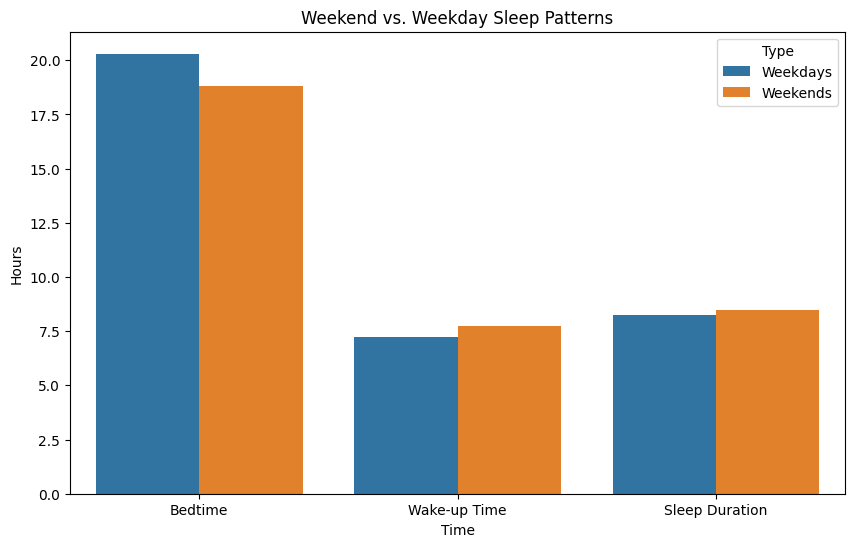

In [112]:
def seconds_since_midnight(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def time_from_seconds(s):
    return datetime.time(s // 3600, (s % 3600) // 60, s % 60)

weekday_mask = data['sleepStartTimestampGMT'].dt.dayofweek < 5
weekend_mask = data['sleepStartTimestampGMT'].dt.dayofweek >= 5

avg_sleep_duration_weekday = data.loc[weekday_mask, 'totalSleepSeconds'].mean() / 3600
avg_sleep_duration_weekend = data.loc[weekend_mask, 'totalSleepSeconds'].mean() / 3600

avg_bedtime_weekday_seconds = data['sleepStartTimestampGMT'][weekday_mask].dt.time.apply(seconds_since_midnight).mean()
avg_bedtime_weekend_seconds = data['sleepStartTimestampGMT'][weekend_mask].dt.time.apply(seconds_since_midnight).mean()
avg_wakeup_weekday_seconds = data['sleepEndTimestampGMT'][weekday_mask].dt.time.apply(seconds_since_midnight).mean()
avg_wakeup_weekend_seconds = data['sleepEndTimestampGMT'][weekend_mask].dt.time.apply(seconds_since_midnight).mean()

data = {
    "Time": ["Bedtime", "Wake-up Time", "Sleep Duration"],
    "Weekdays": [
        avg_bedtime_weekday_seconds / 3600,
        avg_wakeup_weekday_seconds / 3600,
        avg_sleep_duration_weekday
    ],
    "Weekends": [
        avg_bedtime_weekend_seconds / 3600,
        avg_wakeup_weekend_seconds / 3600,
        avg_sleep_duration_weekend
    ]
}

df_plot = pd.DataFrame(data)

df_plot = df_plot.melt(id_vars="Time", var_name="Type", value_name="Hours")

plt.figure(figsize=(10, 6))
sns.barplot(x="Time", y="Hours", hue="Type", data=df_plot)
plt.title("Weekend vs. Weekday Sleep Patterns")
plt.show()

